In [15]:
from pathlib import Path

try:
    from google.colab import drive
    drive.mount("/content/drive")
    ROOT_DATA_DIR = Path("/content/drive/MyDrive/research/driving_dataset")
    DATA_DIR = Path("/content/driving_dataset_preprocessed")
    ALT_DIR_PATH = Path("/content/drive/MyDrive/research/driving_dataset_preprocessed")
    EXP_DIR = Path("/content/drive/MyDrive/research/experiments")
    
    if ALT_DIR_PATH.exists():
        shutil.copytree(ALT_DIR_PATH, DATA_DIR)
except:
    ROOT_DATA_DIR = Path("/home/avishkar/Desktop/research/driving_dataset")
    DATA_DIR = Path("/home/avishkar/Desktop/research/driving_dataset_preprocessed_2")
    EXP_DIR = Path("/home/avishkar/Desktop/research/experiments")
    


LABELS_PATH = ROOT_DATA_DIR/"data.txt"

train : 36324, test: 9082


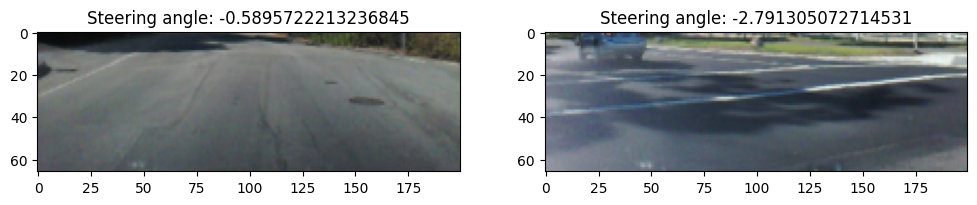

In [16]:
# Dataset

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class DrivingDataset(Dataset):
    def __init__(self, labels_path, data_dir, transform=None):
        with open(Path(labels_path), "r") as f:
            self.labels = f.readlines()
            f.close()
        self.data_dir = Path(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index) :
        img_path, label = self.labels[index].split()
        label=float(label)*np.pi/180
        img = Image.open(self.data_dir/img_path)
        width, height = img.size
        img = img.crop((0, 150, width, height))

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((66,200)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(5),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

BATCH_SIZE = 32
NUM_WORKERS = 2

from torchvision import datasets

dataset = DrivingDataset(labels_path=ROOT_DATA_DIR/"data.txt", data_dir=ROOT_DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = int(len(dataset)-train_size)
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

print(f"train : {len(train_set)}, test: {len(test_set)}")

for i, (imgs, labels) in enumerate(train_loader):
    # img = imgs[0]
    label = labels[0]
    
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title(f"Steering angle: {labels[0].item()}")
    ax1.imshow(imgs[0].permute(1,2,0))

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title(f"Steering angle: {labels[1].item()}")
    ax2.imshow(imgs[1].permute(1,2,0))
    
    # plt.axis('off')
    plt.show()
    break


In [17]:
import torch.nn as nn 
import torch

class DAVE2_mark1(nn.Module):
    def __init__(self):
        super(DAVE2_mark1, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 1 * 18, 100)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.flatten(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x
    
class DAVE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,24,5,stride=2),
            nn.ELU(),
            nn.Conv2d(24,36,5,stride=2),
            nn.ELU(),
            nn.Conv2d(36,48,5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            # nn.ELU(),
            # nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)   
        )
        self.dense_layers=nn.Sequential(
            nn.Linear(in_features=64 * 2 * 10, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.ELU(),
            nn.Linear(in_features=10, out_features=1)
        )
    def forward(self,data):
              
        output = self.conv_layers(data)
        output = output.view(output.size(0), -1)
        output = self.dense_layers(output)
        return output
    
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(24* 31*98, 100)
        self.fc2 = nn.Linear(100, 1)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.drop(x)
        
        return x
        

In [18]:
config ={
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "exp_name":"dave2_10_epoch",
        "num_epoch":10
    }

import time
from tqdm import tqdm
from torchsummary import summary

def main():
    model = DAVE2_mark1()
    summary(model, (3, 66, 200))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(config["num_epoch"]):
        print(f'Epoch {epoch+1} / {config["num_epoch"]}')
        
        # TRAIN
        running_loss = 0
        model.train()
        for i, (imgs, labels) in enumerate(tqdm(train_loader)):
            imgs = imgs.cpu()
            labels = labels.float().unsqueeze(1)
            
            preds = model(imgs).float()
            loss = criterion(preds, labels)

            running_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = running_loss / len(train_loader.dataset)
        print("Training Loss : ", train_loss)
        
        # EVAL
        model.eval()
        correct = 0
        running_test_loss = 0
        for i, (imgs, labels) in enumerate(tqdm(test_loader)):
            imgs = imgs
            labels = labels.float().unsqueeze(1)
            
            predictions = model(imgs)
            loss = criterion(predictions, labels)
            
            running_test_loss += loss.item() * len(imgs)

            # predictions = torch.argmax(predictions, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(test_loader.dataset)
        test_loss = running_test_loss / len(test_loader.dataset)
        print("test loss ",test_loss)
        print("test accuracy: ",accuracy)
            
            

    

In [19]:
main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 31, 98]           1,824
            Conv2d-2           [-1, 36, 14, 47]          21,636
            Conv2d-3            [-1, 48, 5, 22]          43,248
            Conv2d-4            [-1, 64, 3, 20]          27,712
            Conv2d-5            [-1, 64, 1, 18]          36,928
           Flatten-6                 [-1, 1152]               0
           Dropout-7                 [-1, 1152]               0
            Linear-8                  [-1, 100]         115,300
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 50]           5,050
          Dropout-11                   [-1, 50]               0
           Linear-12                    [-1, 1]              51
Total params: 251,749
Trainable params: 251,749
Non-trainable params: 0
-------------------------------

 13%|█▎        | 145/1136 [00:09<01:03, 15.55it/s]


KeyboardInterrupt: 